In [1]:
import os
import resource
import psutil

# Set memory limit to 16GB (adjust if needed)
memory_limit = 16 * 1024 * 1024 * 1024  # 16GB in bytes
resource.setrlimit(resource.RLIMIT_AS, (memory_limit, memory_limit))

# Restrict CPU core usage
p = psutil.Process()  # Get the current process
p.cpu_affinity([0])  # Restrict the process to use only CPU cores 0, 1, 2, and 3

In [2]:
import tensorflow as tf
import psutil
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

import time
import matplotlib.pyplot as plt

# Disable GPU usage
tf.config.set_visible_devices([], 'GPU')

# Optionally disable XLA devices to prevent further warnings
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

# Check available devices
print("Available devices:", tf.config.list_physical_devices())

# Print CPU Count
print("CPU Count:", os.cpu_count())

2025-03-19 07:41:04.735032: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-19 07:41:04.735110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-19 07:41:04.737053: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 07:41:04.746805: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
CPU Count: 256


In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load the GPT-2 model and tokenizer
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Move the model to the desired device (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Apply post-training quantization (PTQ)
# Note: PyTorch provides dynamic and static quantization methods.
# Here, we use dynamic quantization for simplicity.

# Convert the model to a dynamically quantized model
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)

# Alternatively, for static quantization, you would need to prepare the model,
# calibrate it, and then convert it. This requires more steps and is typically
# done with quantization-aware training for better results.

# Example usage
input_text = "Hello, how are you?"
inputs = tokenizer(input_text, return_tensors="pt").to(device)
outputs = quantized_model.generate(**inputs)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))





Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Hello, how are you?

The, the, the, the, the, the, the, the, the,


In [4]:
# Cell 3: Set Pad Token and Model to Evaluation Mode
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Set EOS token as the pad_token

model.eval()  # Set model to evaluation mode

# Define a prompt
prompt = "What is the capital of Denmark?"

# Encode the prompt (tokenize it) with padding
inputs = tokenizer(prompt, return_tensors="pt", padding=True)  # Ensure padding is applied if needed

# Add attention mask to the inputs
attention_mask = inputs['attention_mask']

In [5]:
# Cell 4: Measure Latency Over Multiple Iterations
def measure_latency(tokenizer, model, prompt, iterations=25):
    latencies = []
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)  # Encode the prompt with padding
    attention_mask = inputs['attention_mask']  # Get the attention mask
    
    # Set pad_token_id to eos_token_id if necessary
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    start_time = time.time()
    model.generate(
        inputs['input_ids'], 
        attention_mask=attention_mask,  # Pass the attention mask
        max_length=50,
        pad_token_id=tokenizer.pad_token_id  # Set pad token explicitly
    )
    end_time = time.time()
    # Calculate latency
    latency = end_time - start_time
    return latency

# Measure and print average latency
latency = measure_latency(tokenizer, model, prompt)
print(f"Average Latency: {latency * 1000:.2f} ms")



Average Latency: 1653.40 ms


Average Throughput: 1.83 samples/second


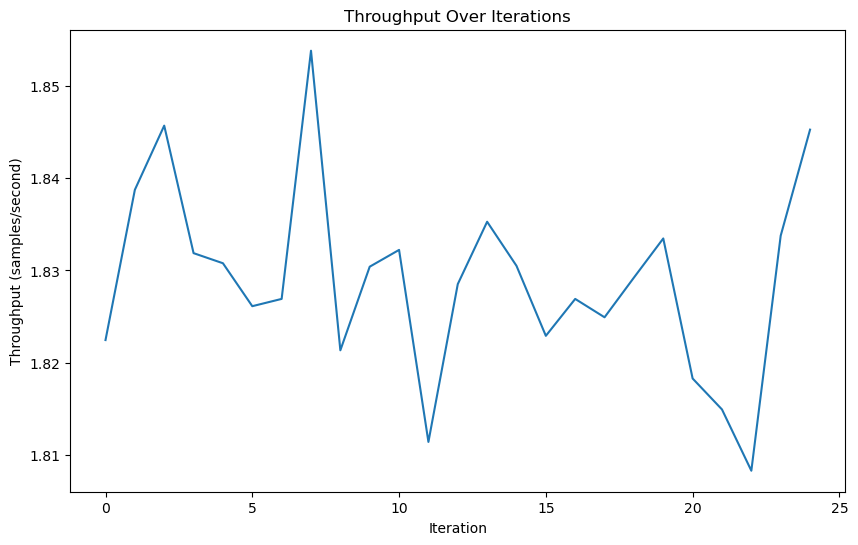

In [6]:
# Cell 5: Measure Throughput Over Multiple Iterations
def measure_throughput(tokenizer, model, prompt, batch_size=8, iterations=25):
    throughputs = []
    inputs = tokenizer([prompt] * batch_size, return_tensors="pt", padding=True, truncation=True, return_attention_mask=True)
    attention_mask = inputs['attention_mask']
    
    # Set pad_token_id to eos_token_id if necessary
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    for _ in range(iterations):
        start_time = time.time()
        model.generate(
            inputs['input_ids'], 
            attention_mask=attention_mask,  # Pass the attention mask
            max_length=50,
            pad_token_id=tokenizer.pad_token_id  # Set pad token explicitly
        )
        end_time = time.time()
        throughput = batch_size / (end_time - start_time)
        throughputs.append(throughput)
    
    average_throughput = sum(throughputs) / len(throughputs)
    return throughputs, average_throughput

# Measure and print average throughput
prompt = "Mary had a little lamb"
throughputs, average_throughput = measure_throughput(tokenizer, model, prompt)
print(f"Average Throughput: {average_throughput:.2f} samples/second")

# Plot throughput over iterations
plt.figure(figsize=(10, 6))
plt.plot(throughputs)
plt.title('Throughput Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Throughput (samples/second)')
plt.show()

In [7]:
# Set the pad_token to eos_token (or add a custom pad_token if necessary)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Set EOS token as the pad_token

# Set the model to evaluation mode
model.eval()

# Define a prompt
prompt = "What is the capital of Denmark?"

# Encode the prompt (tokenize it) with padding
inputs = tokenizer(prompt, return_tensors="pt", padding=True)  # Ensure padding is applied if needed

# Add attention mask to the inputs
attention_mask = inputs['attention_mask']

# Generate text from the model with do_sample set to True for sampling-based generation
outputs = model.generate(
    inputs['input_ids'], 
    attention_mask=attention_mask,  # Provide attention mask
    max_length=100,                  # Maximum number of tokens to generate
    num_return_sequences=1,         # Number of output sequences
    no_repeat_ngram_size=2,         # Prevent repetition
    top_p=0.92,                     # Nucleus sampling (controls randomness)
    top_k=50,                       # Top-k sampling
    temperature=0.85,               # Lower temperature makes text less random
    do_sample=True,                 # Enable sampling mode to use top_p, top_k, and temperature
    pad_token_id=tokenizer.pad_token_id  # Set pad token explicitly
)

# Decode the generated tokens back into text
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(generated_text)

What is the capital of Denmark?

In December last year, Denmark voted in favour of the Danish Labour Party, which included Danish Prime Minister Helle Thorning-Schmidt, a conservative and left-leaning politician. The Danish People's Party has also supported the party, as have the Conservatives.
, according to a statement from the coalition government, with the support of its parliamentary majority. This support includes the government of Justice and Social Affairs and the opposition Greens. For instance, for the


Average Memory Usage: 36549.36 MB


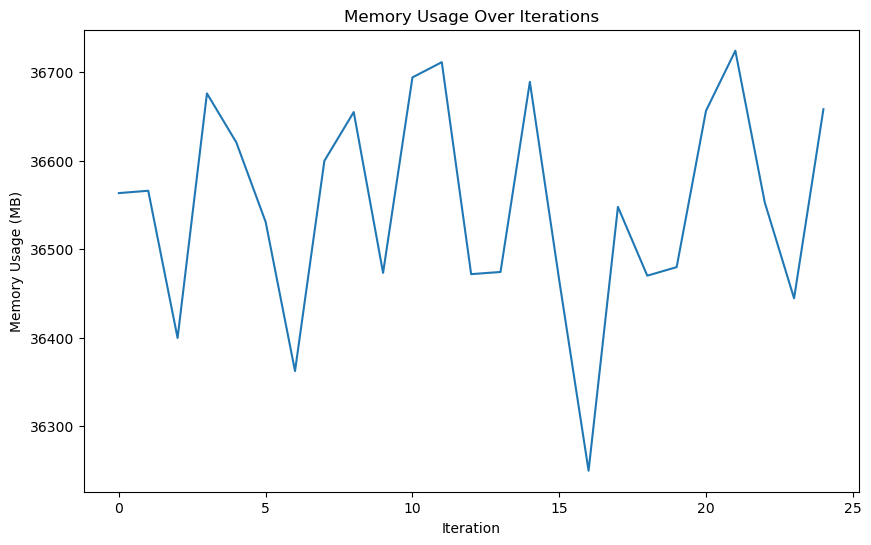

In [8]:
# Cell 6: Track Memory Usage
def get_memory_usage():
    memory = psutil.virtual_memory()
    return memory.used  # Return memory used in bytes

def track_memory_usage(model, inputs, attention_mask, iterations=25):
    memory_usages = []
    for _ in range(iterations):
        outputs = model.generate(
            inputs['input_ids'],
            attention_mask=attention_mask,  # Provide attention mask
            max_length=100,  # Maximum number of tokens to generate
            num_return_sequences=1,  # Number of output sequences
            no_repeat_ngram_size=2,  # Prevent repetition
            top_p=0.92,  # Nucleus sampling (controls randomness)
            top_k=50,  # Top-k sampling
            temperature=0.85,  # Lower temperature makes text less random
            do_sample=True,  # Enable sampling mode to use top_p, top_k, and temperature
            pad_token_id=tokenizer.pad_token_id  # Set pad token explicitly
        )
        memory_usage = get_memory_usage()
        memory_usages.append(memory_usage)
    
    average_memory_usage = sum(memory_usages) / len(memory_usages)
    return memory_usages, average_memory_usage

# Define inputs and attention mask
prompt = "What is the capital of Denmark and what is the capital of India?"
inputs = tokenizer(prompt, return_tensors="pt", padding=True)
attention_mask = inputs['attention_mask']

# Track memory usage over iterations
memory_usages, average_memory_usage = track_memory_usage(model, inputs, attention_mask)

# Print average memory usage
print(f"Average Memory Usage: {average_memory_usage / (1024 * 1024):.2f} MB")

# Plot memory usage over iterations
plt.figure(figsize=(10, 6))
plt.plot([usage / (1024 * 1024) for usage in memory_usages])  # Convert bytes to MB for plotting
plt.title('Memory Usage Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Memory Usage (MB)')
plt.show()
